<a href="https://colab.research.google.com/github/xcellentbird/TOY-PROJECTS/blob/main/AutoEncoder%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_Feature_Engineering_%EA%B7%B8%EB%A6%AC%EA%B3%A0_Clustering/AutoEncoder%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_Feature_Engineering_%EA%B7%B8%EB%A6%AC%EA%B3%A0_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈 및 데이터셋 준비

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import datasets, transforms

mnist_train_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_test_dataset = datasets.FashionMNIST('data', train=False, download=True, transform=transforms.ToTensor())

type(mnist_train_dataset), len(mnist_train_dataset)

(torchvision.datasets.mnist.FashionMNIST, 60000)

참고:
- Tranposed Convolution and AutoEncoder: https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html

- PyTorch CONVTRANSPOSE2D: https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

Tranposed Convolution Output Size
* $OUT = (IN−1)×stride − 2×padding + dilation×(kernel size−1) + output padding + 1$

아래 코드와 같이 Stride나 Padding없이 Conv와 같은 kernel 크기의 ConvTranpose filter를 적용하면, Conv filter를 적용하기 전의 크기로 돌아오는 것을 볼 수 있다.

In [ ]:
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
convt = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5)

x = torch.randn(32, 3, 64, 64)
y = conv(x)
x.shape, y.shape, convt(y).shape

(torch.Size([32, 3, 64, 64]),
 torch.Size([32, 16, 60, 60]),
 torch.Size([32, 3, 64, 64]))

In [ ]:
x.reshape((x.size(0),-1)).shape

torch.Size([32, 12288])

이는 Conv의 역연산(Deconvolution)과 비슷해보이지만, 엄연히 다른 연산이다.

In [ ]:
# 크기가 되돌아오지만, 결과값이 되돌아오지 않는다.
x.sum() == convt(y).sum()

tensor(False)

stride를 적용해도 같다. 하지만, stirde나 dilation을 적용한 convt(tranposed convolution) 연산 결과, conv 연산 전과 같이 돌아오지 않는 경우도 있다. 그 이유는 conv연산의 나누는 연산 과정에서 나머지를 떼어내고 몫을 구하는 경우가 있기 때문이다. 그래서 이를 고려하여, convt에서는 output_padding을 이용해 추가적으로 한쪽에 padding을 적용해준다. 적분에서 정적분 결과에 상수 C를 더해주는 것과 비슷한 느낌으로 이해해주면 된다. (padding과 output_padding은 같지 않다!)

Convolution Output Size
* $Conv Output = (Conv In + 2 × padding - filter size) // stride + 1$

In [ ]:
conv_stride = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2)
convt_stride = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5, stride=2)
convt_outpad = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5, stride=2, output_padding=1)

s_y = conv_stride(x)
x.shape, s_y.shape, convt_stride(s_y).shape, convt_outpad(s_y).shape

(torch.Size([32, 3, 64, 64]),
 torch.Size([32, 16, 30, 30]),
 torch.Size([32, 3, 63, 63]),
 torch.Size([32, 3, 64, 64]))

# Model

## 분류기(Classifer) 모드를 위한 FC 모델

In [ ]:
class Classifier(nn.Module):
  def __init__(self, in_features, num_classes):
    super(Classifier, self).__init__()
    self.fc1 = nn.Linear(in_features, 64)
    self.fc2 = nn.Linear(64, num_classes)

  def forward(self, x):
    x = F.dropout(F.relu(self.fc1(x)))
    x = torch.sigmoid(self.fc2(x))
    return x

## AutoEncoder 모델
- 기본적으로 AutoEncoder 모델로 Encoder 결과와 Decoder 결과를 반환한다.
- classifier_mode를 True로 설정할 경우, 분류기 모델로도 작동하며, 추가적으로 label별 예측 확률값들(targets)을 반환한다.

In [ ]:
# 층을 늘리기보다는 cnn층의 변수 개수를 늘렸을 때, 학습 효과(loss 최소화)가 좋았다.
# BatchNorm2d도 사용해보았지만, 효과가 좋지 않았다. 
class Autoencoder(nn.Module):
  def __init__(self, classifier_mode=False, num_classes=10):
    super(Autoencoder, self).__init__()
    self.classifier_mode = classifier_mode
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, stride=2, padding=1),
        nn.SiLU(),
        nn.Conv2d(32, 128, 3, stride=2, padding=1),
        nn.SiLU(),
        nn.Conv2d(128, 512, 7),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(512, 128, 7),
        nn.SiLU(),
        nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
        nn.SiLU(),
        nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )
    self.classifier = Classifier(in_features=512,
                                 num_classes=num_classes)


  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    # 분류기 모드일 경우
    out = None
    if self.classifier_mode:
      out = encoded.reshape((encoded.size(0), -1))
      out = self.classifier(out)
    
    return encoded, decoded, out

# Draw Loss Graph

In [ ]:
def loss_graph(num_epochs, loss_list):
  plt.plot(range(num_epochs), loss_list)
  plt.grid(linestyle='--')
  plt.show()

# Train Func

In [ ]:
def train(model, train_dataset, valid_dataset, num_epochs=5, batch_size=64, lr = 1e-3):
  from torch.nn import MSELoss
  from torch.optim import Adam
  from torch.optim.lr_scheduler import StepLR

  # torch.manual_seed(42)
  # Device 설정
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print("training on",device)

  # 분류기 모드 적용
  classifier_mode = model.classifier_mode

  # 데이터 로더 준비
  train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
  
  model = model.to(device)
  if classifier_mode:
    criterion = torch.nn.CrossEntropyLoss()
    lr /= 10
  else:
    criterion = MSELoss().to(device)
  optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
  scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

  outputs = []
  loss_list = [[None, None] for _ in range(num_epochs)]
  recon = None
  for epoch in range(num_epochs):
    model.train()
    for train_imgs, train_labels in train_loader:
      train_imgs = train_imgs.to(device)
      _, train_recon, targets = model(train_imgs)

      if classifier_mode:
        train_labels = train_labels.to(device)
        train_loss = criterion(targets, train_labels)
      else:
        train_loss = criterion(train_recon, train_imgs)

      train_loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    print('Epoch: {} / {}\nTrain Loss: {:.4f}'.format(epoch+1, num_epochs, float(train_loss)))

    model.eval()
    valid_score = 0
    for imgs, labels in valid_loader:
      imgs = imgs.to(device)
      _, recon, targets = model(imgs)

      if classifier_mode:
        labels = labels.to(device)
        valid_loss = criterion(targets, labels)

        # get score
        target_for_score = np.argmax(targets.to('cpu').detach().numpy(), axis=1)
        label_for_score = labels.to('cpu').detach().numpy()
        valid_score += (target_for_score == label_for_score).sum()
      else:
        valid_loss = criterion(recon, imgs)
    
    scheduler.step()
    outputs.append((epoch, imgs, recon, labels),)

    print('Valid Loss: {:.4f}'.format(float(valid_loss)))
    if classifier_mode:
      print('Valid Score: {:.2f}'.format(valid_score * 100 / len(valid_dataset)))  
    
    loss_list[epoch] = [float(train_loss), float(valid_loss)]
    print('----------')

  # loss graph 출력
  loss_graph(num_epochs, loss_list)

  return outputs

# Execute

training on cuda
Epoch: 1 / 50
Train Loss: 0.0103
Valid Loss: 0.0090
----------
Epoch: 2 / 50
Train Loss: 0.0076
Valid Loss: 0.0064
----------
Epoch: 3 / 50
Train Loss: 0.0057
Valid Loss: 0.0053
----------
Epoch: 4 / 50
Train Loss: 0.0046
Valid Loss: 0.0033
----------
Epoch: 5 / 50
Train Loss: 0.0031
Valid Loss: 0.0045
----------
Epoch: 6 / 50
Train Loss: 0.0035
Valid Loss: 0.0040
----------
Epoch: 7 / 50
Train Loss: 0.0043
Valid Loss: 0.0036
----------
Epoch: 8 / 50
Train Loss: 0.0050
Valid Loss: 0.0037
----------
Epoch: 9 / 50
Train Loss: 0.0034
Valid Loss: 0.0039
----------
Epoch: 10 / 50
Train Loss: 0.0036
Valid Loss: 0.0027
----------
Epoch: 11 / 50
Train Loss: 0.0032
Valid Loss: 0.0037
----------
Epoch: 12 / 50
Train Loss: 0.0034
Valid Loss: 0.0025
----------
Epoch: 13 / 50
Train Loss: 0.0037
Valid Loss: 0.0034
----------
Epoch: 14 / 50
Train Loss: 0.0031
Valid Loss: 0.0025
----------
Epoch: 15 / 50
Train Loss: 0.0032
Valid Loss: 0.0038
----------
Epoch: 16 / 50
Train Loss: 0.003

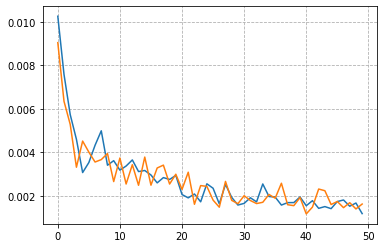

In [ ]:
model = Autoencoder()
max_epochs = 50
outputs = train(model, mnist_train_dataset, mnist_test_dataset, num_epochs=max_epochs)

## AutoEncoder 결과 시각화

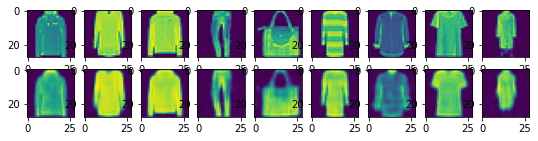

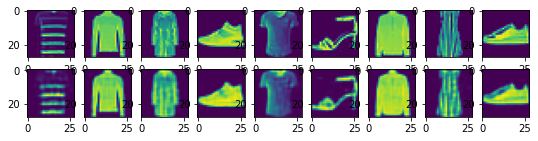

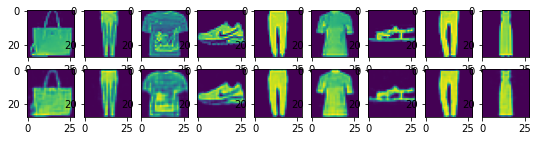

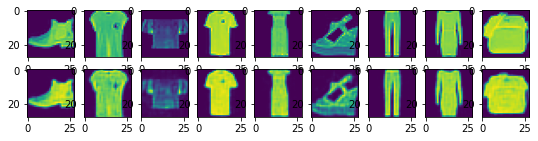

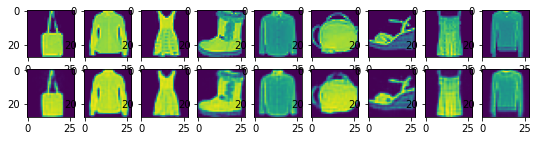

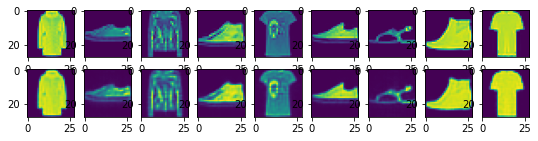

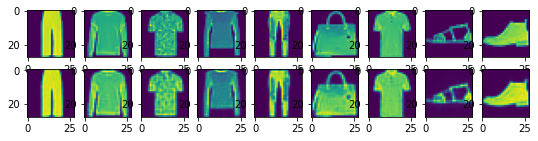

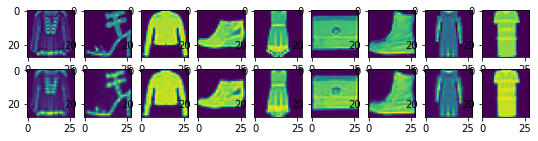

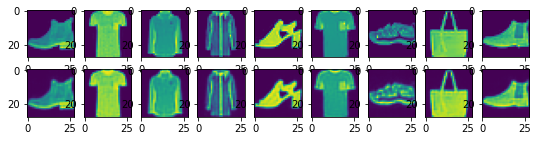

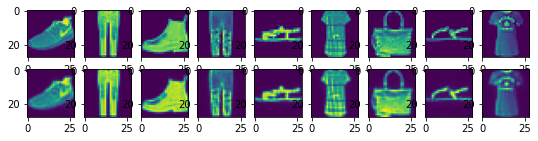

In [ ]:
for k in range(0, max_epochs, 5):
  plt.figure(figsize=(9, 2))
  imgs = outputs[k][1].to('cpu').detach().numpy()
  recon = outputs[k][2].to('cpu').detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9:
      break
    plt.subplot(2, 9, i+1)
    plt.imshow(item[0])
  for i, item in enumerate(recon):
    if i >= 9:
      break
    plt.subplot(2, 9, 9+i+1)
    plt.imshow(item[0])

# Get Features from Encoder

이미지를 입력으로 넣었을 때, Encoder에서 나오는 값을 feature로 선정한다.

In [ ]:
model.eval()
model.to('cuda')
encoded_outputs = []
test_loader = torch.utils.data.DataLoader(mnist_test_dataset,
                                             batch_size=64,
                                             shuffle=True,)
for i, (imgs, labels) in enumerate(test_loader):
  imgs = imgs.to('cuda')
  
  encoded_output, decoded_output, _ = model(imgs)
  encoded_output = encoded_output.to('cpu').detach().numpy()
  for label, features in zip(labels, encoded_output):
    encoded_outputs.append([label.detach().numpy()] + list(features.squeeze()))

In [ ]:
df = pd.DataFrame(encoded_outputs)
df = df.rename(columns={0:'label'})

In [ ]:
df.head()

,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512
0,2,0.407909,0.237850,-0.300702,-0.288830,-0.547916,-0.229443,0.026786,-0.288715,-0.087656,-0.326146,0.264580,-0.189406,-0.573359,0.149441,-0.239284,0.115245,-0.183807,-0.071515,0.152986,0.319975,0.756317,-0.497267,0.069593,0.568623,0.084908,0.075615,0.352722,0.062692,-0.044506,0.017730,-1.641672,0.230648,-0.082876,0.049051,-7.177147,0.181622,-0.069757,-0.311123,0.345142,...,-0.638092,1.802102,-0.064329,-0.017724,0.059347,-0.004275,0.038176,0.185040,0.093795,0.001189,-0.165198,0.144893,-0.265651,-0.020796,0.291617,0.530846,-0.260300,0.060195,0.317242,-0.056817,1.928782,-0.404768,0.449277,-0.013327,-3.979941,0.105096,0.167706,-0.370314,-0.561543,-0.069265,-1.065834,-0.067598,-0.403842,0.037085,-1.198968,-0.417954,-0.121815,-0.083604,-0.001227,-0.264122
1,2,-0.056069,-0.226379,0.072870,-0.194328,-0.207391,-0.070635,0.058176,-0.587775,-0.025443,0.099024,0.663117,-0.311816,-0.849001,-0.158509,-0.072909,0.121593,0.178887,0.051608,0.371884,0.311043,1.091025,-0.507619,-1.011941,-0.998735,0.245993,0.085376,-0.146130,0.543133,0.091341,-0.046605,0.475916,0.186016,-0.283031,0.115854,-4.907986,-0.070216,-0.102733,0.141473,-0.323838,...,0.344343,0.234877,-0.148612,0.197959,-0.302632,-0.075809,0.029454,0.172866,0.105966,0.005699,0.159304,0.037484,-0.319753,0.158312,0.253283,0.831973,-0.265489,-0.845074,0.547312,-0.006711,-0.193859,-0.239113,-0.280684,0.100103,-1.087069,-0.060829,0.444448,-0.043564,-0.703409,0.162464,-0.052704,0.079357,-0.794588,-0.430870,-0.079290,-0.361210,0.015640,0.179822,-0.014383,0.103950
2,4,0.141596,-0.147981,0.283128,-0.022633,0.909673,1.251267,-1.079347,0.810129,-0.017919,0.201013,-0.323239,-0.237615,-0.266128,0.102842,0.018561,-0.043078,-0.506402,-0.134980,0.498133,-0.369095,-0.385743,0.456791,0.535978,0.651664,0.107175,-0.092659,-0.050296,0.046423,-0.170186,-0.217285,2.253222,0.168996,-0.222541,-0.059531,-2.792027,0.147828,0.157114,-0.285327,0.940090,...,-1.004558,-4.406951,1.265968,-0.176692,0.361035,-0.593648,-0.060247,0.183779,0.107351,0.080261,0.694930,-0.256488,0.113665,-0.098543,-0.006613,0.158286,-0.410926,0.156904,0.115047,0.371424,-0.295315,-0.199109,-0.251633,-0.106062,2.136932,-0.058111,0.084922,-0.238674,-0.336534,-0.065045,-0.933850,-0.321274,-0.404026,0.065687,-0.510032,-0.233045,0.003057,-0.029756,0.142292,-0.021050
3,5,0.045782,0.847280,0.004071,-0.087685,-0.130932,-0.307740,-1.412325,0.398784,0.141230,-0.616711,0.404957,0.283396,1.049729,-0.118227,-0.482283,0.288434,-0.506658,0.110756,-1.072459,-0.232729,0.655200,-0.469583,-0.305222,0.360069,-0.037797,0.317950,-0.018345,-0.241252,-1.133925,0.177053,-1.246010,0.317004,-0.345908,-0.125901,-12.951674,0.012068,0.575644,-0.087646,-0.604230,...,-0.187410,-0.878305,-0.470064,-0.057143,0.334876,-0.162874,-0.156941,0.218815,0.445021,0.110398,0.451718,-0.189998,0.543272,0.006701,0.273677,0.191558,-0.308816,0.104346,0.157645,0.175451,2.486404,-0.446167,-0.211271,-0.065704,-0.724743,-0.260848,0.217249,-0.014960,-0.794084,-0.240312,-0.774607,-0.003206,0.115026,0.114148,-0.292537,0.115674,-0.193944,-0.117234,-0.010307,-0.004694
4,3,0.155734,-0.184902,-0.086100,-0.069075,0.034363,-0.179602,0.566385,-0.019665,0.026216,0.093192,-0.939889,-0.145786,-1.448063,-0.326530,0.017465,0.122955,0.315632,-0.055300,-1.565996,0.555403,0.311326,0.469828,0.774319,-1.655503,-0.029558,0.081442,0.023440,-0.194030,-1.231771,-0.206805,5.455624,0.067469,-0.001502,-0.007306,-7.037464,0.081486,0.738332,0.212519,0.093222,...,-0.565812,-0.191010,-0.525329,-0.103166,-0.347344,-0.615877,0.013472,0.283087,-0.106245,0.042199,-0.249951,-0.249193,-0.673190,-0.113458,-0.032071,-0.378912,-0.024669,-0.365439,-0.137915,0.063054,-0.110264,-0.050150,-0.005224,-0.135462,-1.273275,0.276816,0.069791,-0.064426,0.502510,-0.036145,

In [ ]:
df.label = df.label.astype('int')
df.label.unique()

array([2, 4, 5, 3, 1, 7, 8, 6, 9, 0])

# Encoder Features Func

In [ ]:
def get_encoder_features(model, test_dataset):
  # Device 설정
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print("it's on",device)

  test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=64,
                                              shuffle=True,)
  
  model.eval()
  model.classifier_mode = False
  model.to(device)

  encoded_outputs = []
  for i, (imgs, labels) in enumerate(test_loader):
    imgs = imgs.to(device)
    
    encoded_output, decoded_output, _ = model(imgs)
    encoded_output = encoded_output.to('cpu').detach().numpy()
    for label, features in zip(labels, encoded_output):
      encoded_outputs.append([label.detach().numpy()] + list(features.squeeze()))

  ret_df = pd.DataFrame(encoded_outputs)
  ret_df = ret_df.rename(columns={0:'label'})
  ret_df.label = ret_df.label.astype('int')

  return ret_df

In [ ]:
new_features = get_encoder_features(model, mnist_test_dataset)
new_features

it's on cuda


,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512
0,5,-0.257386,-0.451392,-0.086977,-0.422641,-0.359127,1.929502,-0.592140,-0.452659,0.105397,-0.234940,-1.570745,-0.264247,1.204936,-0.056024,0.024746,-0.091774,-0.197280,-0.240927,-0.360548,-0.623353,0.542264,0.288956,0.349664,-0.173645,0.113536,0.086285,-0.226574,0.483769,0.871859,0.024631,1.743373,0.171492,0.384542,-0.125021,-9.188639,0.366538,0.207081,0.834382,-0.435343,...,0.390597,-0.104244,1.111463,-0.548653,-0.009933,-0.678987,0.007973,-0.011553,-0.172625,0.444932,0.368073,-0.072802,1.163408,0.013172,0.161439,0.579693,-0.127441,-0.005495,0.151321,-0.092763,1.028861,-0.136896,-0.038105,-0.018780,1.501146,-0.253363,0.642931,0.627773,-0.626644,-0.056348,1.430236,0.955010,0.350343,0.790270,1.254178,-0.151366,0.021795,-0.142676,-0.099646,-0.098902
1,8,0.517375,-0.621756,-0.225617,-0.349375,0.253168,-0.657563,-0.144075,0.899775,-0.059010,0.115351,-1.668841,-0.347673,0.841992,0.017547,0.211579,0.342751,0.071467,0.433862,0.756913,0.106355,-0.777535,-0.179672,0.952247,-0.218804,0.195238,0.075856,-0.299153,-0.532307,-0.185918,0.523996,1.057988,0.406903,-0.098330,-0.046842,13.861651,0.193384,0.305808,0.238338,0.954992,...,0.598688,0.318686,0.385171,0.199744,0.003818,0.841275,0.228725,0.398133,-0.059815,-0.340440,0.307078,-0.135982,-0.542447,-0.225035,0.354411,-0.681676,-0.126460,-0.230779,-0.027184,0.170620,-1.522902,-0.425223,0.424773,-0.378111,-1.719435,-0.252401,0.376233,-0.553453,-0.279711,-0.136054,1.960309,0.848104,-0.898167,0.039430,-1.540491,-0.298810,-0.213620,0.070593,0.146012,0.231498
2,4,0.003978,0.090636,-0.234996,-0.188612,0.682206,-0.118820,0.058803,0.226967,0.229645,-0.021380,-0.249241,0.042822,-2.908371,0.004124,0.705093,0.340550,-0.791749,0.042444,0.600997,-0.124084,-0.455138,-0.263199,-1.177888,0.434820,0.103174,0.233232,0.307146,-0.264794,0.019759,0.015972,-2.835711,-0.070258,-0.013545,0.234111,3.683961,0.355360,0.092128,-0.684282,-1.128013,...,-0.284616,0.364199,0.218220,0.100067,-0.062936,0.070112,-0.058455,0.181265,-0.009364,-0.073055,-0.179700,0.053840,0.391087,-0.426911,0.057648,-0.803950,0.050350,0.417743,-0.265848,-0.128919,-0.049322,-0.027062,-0.500456,0.146483,2.345361,0.032418,0.464234,0.208651,0.107966,0.026512,-0.663327,0.123670,-0.108723,-0.414877,2.526071,-0.217101,-0.203306,-0.444809,0.114906,0.055791
3,1,-0.251577,0.289668,-0.120409,0.094839,0.069101,-0.960836,-0.399145,-0.275870,0.088517,-0.620385,-0.757988,-0.109073,-1.011038,-0.251005,-0.514261,0.333528,0.553627,-0.102273,-1.719982,-0.406858,0.035706,0.007630,0.115157,-0.620962,-0.038402,-0.038640,0.449421,-0.236802,-1.618756,0.272608,1.935840,0.110907,-0.136797,0.042337,-9.624476,-0.021301,-0.334564,-0.746182,0.110807,...,-0.060749,-6.141800,-0.749909,0.174724,0.359461,-0.227217,0.254938,0.167910,-0.331768,-0.002680,0.082833,-0.146580,-1.078649,-0.246005,-0.179188,0.866546,-0.098548,0.245909,0.729574,0.168894,-0.116185,0.017316,0.353431,-0.222053,-0.864247,0.083353,-0.377240,0.064911,0.955019,0.013479,-0.137837,0.481398,-0.723909,-0.299050,-2.008312,-0.295079,-0.113597,-0.182039,0.202916,0.037361
4,2,0.408536,-0.822254,-0.035646,-0.096386,-0.353658,-0.486025,-0.038740,-0.782018,-0.213435,0.184221,-0.472718,-0.030005,-1.462951,-0.140298,-0.735008,0.281601,-0.683250,0.102405,-0.709235,0.312042,0.421468,-0.753097,-0.583219,-1.269529,0.010165,-0.004610,0.858573,-0.267028,0.521814,-0.510247,2.515141,0.042902,0.030733,0.000477,-4.759194,0.170056,0.743716,-0.414346,0.230192,...,-0.381503,-0.064201,0.182662,-0.030646,0.076259,-0.604598,0.103364,0.374334,-0.057893,-0.196057,-0.261356,-0.277138,0.108070,-0.112829,0.038476,0.616879,-0.289180,-0.572158,-0.396484,0.171122,0.613780,-0.254171,-0.066724,0.019845,-2.528660,-0.090975,-0.120351,-0.392943,-0.176715,0.037230,0.653015,-0.0

# Cluster Test

Encoder를 이용해 얻은 Feature로 Kmeans Clustering을 진행해본다. 어떻게 군집이 나눠지게 될까?

In [ ]:
from sklearn.cluster import KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

In [ ]:
cluster = kmeans.fit_transform(df[range(1, 513)])

In [ ]:
cluster = pd.concat([pd.DataFrame(cluster), df.label], axis=1)
cluster.head()

,0,1,label
0,19.768974,30.218798,2
1,19.115738,33.946697,2
2,19.687410,29.109796,4
3,32.436759,18.795793,5
4,21.926912,39.497424,3


In [ ]:
cluster['cluster'] = [np.argmax(k) for k in cluster[range(n_clusters)].values]

In [ ]:
class_to_idx = mnist_test_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
idx_to_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [ ]:
cluster.label = cluster.label.map(idx_to_class)

In [ ]:
cluster.head()

,0,1,label,cluster
0,19.768974,30.218798,Pullover,1
1,19.115738,33.946697,Pullover,1
2,19.687410,29.109796,Coat,1
3,32.436759,18.795793,Sandal,0
4,21.926912,39.497424,Dress,1


군집화한 결과에서 점수가 높은 쪽을 군집으로 선택하게 했고 class값을 얻어냈다.

In [ ]:
result = cluster.groupby(by='label')['cluster'].describe()
result

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Ankle boot,1000.0,0.043,0.202959,0.0,0.0,0.0,0.0,1.0
Bag,1000.0,0.393,0.488661,0.0,0.0,0.0,1.0,1.0
Coat,1000.0,0.976,0.153126,0.0,1.0,1.0,1.0,1.0
Dress,1000.0,0.967,0.178726,0.0,1.0,1.0,1.0,1.0
Pullover,1000.0,0.967,0.178726,0.0,1.0,1.0,1.0,1.0
Sandal,1000.0,0.005,0.070569,0.0,0.0,0.0,0.0,1.0
Shirt,1000.0,0.926,0.261902,0.0,1.0,1.0,1.0,1.0
Sneaker,1000.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0
T-shirt/top,1000.0,0.955,0.207408,0.0,1.0,1.0,1.0,1.0


- mean 평균은 해당 class가 주로 몇번째 군집을 이루고 있는 지를 뜻한다. 
- std 분산은 확신을 의미한다고 할 수 있다. std가 작을수록 해당 class에 대해 더 자주 같은 군집을 택했다는 뜻이 될 수 있다.



- 그 후 mean을 이용하여 다시 군집을 나눠본다. 

In [ ]:
kmean2 = KMeans(n_clusters=n_clusters,)
label = kmean2.fit_transform(result[['mean']])
label_mapping = [np.argmax(k) for k in label]

In [ ]:
result['cluster']  = label_mapping #['상/하의' if t >= 0.5 else '잡화' for t in result['mean']]

In [ ]:
result[['std','mean','cluster']]

,std,mean,cluster
label,,,
Ankle boot,0.202959,0.043,0
Bag,0.488661,0.393,0
Coat,0.153126,0.976,1
Dress,0.178726,0.967,1
Pullover,0.178726,0.967,1
Sandal,0.070569,0.005,0
Shirt,0.261902,0.926,1
Sneaker,0.000000,0.000,0
T-shirt/top,0.207408,0.955,1


- 2개의 군집으로 나눴을 경우 위와 같이 도표를 얻을 수 있었다. mean과 std는 cluster 결정 요인에 해당하기 때문에 같이 출력하였다.
- 군집된 것을 보면, 의류(상/하의)와 잡화로 나눠진 것을 확인할 수 있었다. CNN 모델은 이미지 상의 물건이 어떠한 용도인지 모르고, 오로지 이미지로만 판별하기 때문에, Encoder 모델은 팔/발 소매?의 여부를 보고 나눈 게 아닐까 싶다.

# Cluster Func

In [ ]:
def clustering(n_clusters, datas, label, idx_to_class=None):
  from sklearn.cluster import KMeans
  import numpy as np
  import pandas as pd

  kmeans = KMeans(n_clusters=n_clusters)
  cluster_per = kmeans.fit_transform(datas)
  cluster = pd.DataFrame([np.argmax(k) for k in cluster_per])

  cluster.index = label.index
  cluster_label = pd.concat([cluster, label], axis=1)
  column_mapping = {k: v for k, v in zip(cluster_label.columns, ['cluster', 'label'])}
  cluster_label = cluster_label.rename(columns=column_mapping)

  if idx_to_class:
    cluster_label.label = cluster_label.label.map(idx_to_class)
  result = cluster_label.groupby(by='label')['cluster'].describe()

  kmean2 = KMeans(n_clusters=n_clusters)
  mean_std_cluster = kmean2.fit_predict(result[['mean',]])
  result['cluster']  = mean_std_cluster

  return result[['std','mean','cluster']]

n_clusters를 2보다 높게 늘려서 결과를 검토해보았다. 

매번 군집화마다 결과는 조금씩 달라졌다. 

주로 Bag와 Ankle boot가 같은 군집으로 많이 나오기도 하고, 아래와 같이 다른 군집으로 분류되기도 하는 것을 관찰 할 수 있었다.

In [ ]:
clustering(n_clusters=7, datas=df[range(1,513)], label=df['label'], idx_to_class=idx_to_class)

,std,mean,cluster
label,,,
Ankle boot,1.646995,3.761,5
Bag,0.915898,4.813,6
Coat,0.587027,3.912,3
Dress,1.309412,4.034,1
Pullover,0.711974,3.960,3
Sandal,1.639745,5.118,4
Shirt,0.888200,3.917,3
Sneaker,1.789255,4.887,0
T-shirt/top,0.864001,4.057,1


특히, class의 수만큼 나눴을 때, 모두 각각의 군집으로 나눠진 것을 관찰할 수 있었다. 더군다나, 매번 군집화를 실행해도 결과는 똑같이 서로 다른 군집으로 나눠졌다.

중요한 점은 AutoEncoder모델이나 Kmeans모델에 해당 label을 지도학습해주지 않았다는 것이다.

이를 통해서, 군집화는 classifier로써도 작동할 수 있다는 것을 유추할 수 있었다. n_clusters를 늘릴 수록 우리가 모르는 군집(cluster)으로 분류(classification) 할 수 있을 지도 모른다.

In [ ]:
clustering(n_clusters=10, datas=df[range(1,513)], label=df['label'], idx_to_class=idx_to_class)

,std,mean,cluster
label,,,
Ankle boot,2.166924,8.056,9
Bag,2.393371,7.248,3
Coat,2.415946,1.138,6
Dress,2.185927,3.050,2
Pullover,2.794940,1.761,1
Sandal,1.468521,8.098,4
Shirt,2.919469,2.215,7
Sneaker,0.595801,8.876,0
T-shirt/top,2.507401,1.585,8


# Weight Initialization

이번에는 분류기로 pretraining을 시키고, 전이 학습된 모델의 분류기만 떼어내어 Decoder를 붙여 결과가 달라지는 지 실험할 것이다. 

가설은 이러하다.

1. 지도학습된 모델을 가져오기 때문에, 전이학습의 원리처럼 적은 연산으로도 Autoencoder를 학습할 수 잇을 것이다.

2. 지도학습된 모델로 feature를 얻어냈을 때, 인간이 개입한 다른 결과가 나올 수도 있을 것이다.

먼저 모델을 Classifier로서 조금 더 확실하게 학습이 되도록 epoch를 높게 설정하였다. 

Train 함수를 보면 알겠지만, Classifier모드일 때는 lr를 더 작게 설정하였고(실험을 근거로한 parameter tuning)

loss function도 MSELoss에서 CrossEntropyLoss로 변경하여 Softmax(log함수)에 대응할 수 있게 하였고, (batch_size, num_class), (batch_size) shape끼리 간편하게 loss를 구할 수 있게 하였다.

training on cuda
Epoch: 1 / 40
Train Loss: 1.6680
Valid Loss: 1.7372
Valid Score: 66.90
----------
Epoch: 2 / 40
Train Loss: 1.6441
Valid Loss: 1.6245
Valid Score: 71.21
----------
Epoch: 3 / 40
Train Loss: 1.6711
Valid Loss: 1.7643
Valid Score: 71.85
----------
Epoch: 4 / 40
Train Loss: 1.5778
Valid Loss: 1.6625
Valid Score: 75.46
----------
Epoch: 5 / 40
Train Loss: 1.5681
Valid Loss: 1.6137
Valid Score: 76.37
----------
Epoch: 6 / 40
Train Loss: 1.6207
Valid Loss: 1.5811
Valid Score: 77.66
----------
Epoch: 7 / 40
Train Loss: 1.5592
Valid Loss: 1.4969
Valid Score: 77.72
----------
Epoch: 8 / 40
Train Loss: 1.5925
Valid Loss: 1.6163
Valid Score: 79.04
----------
Epoch: 9 / 40
Train Loss: 1.5674
Valid Loss: 1.5432
Valid Score: 80.32
----------
Epoch: 10 / 40
Train Loss: 1.5123
Valid Loss: 1.5913
Valid Score: 80.73
----------
Epoch: 11 / 40
Train Loss: 1.5638
Valid Loss: 1.6034
Valid Score: 81.72
----------
Epoch: 12 / 40
Train Loss: 1.5304
Valid Loss: 1.5709
Valid Score: 82.59
-------

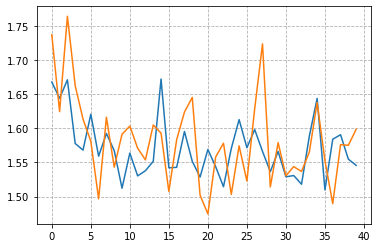

In [ ]:
classes = mnist_train_dataset.classes
model = Autoencoder(classifier_mode=True, num_classes=len(classes))
max_epochs = 40
outputs = train(model, mnist_train_dataset, mnist_test_dataset, num_epochs=max_epochs)

다음으로 그 전보다 작은 epoch로 autoencoder를 학습시킨다.
모델의 classifier_mode를 False로 바꿈으로써 쉽게 모드를 바꿀 수 있도록 설정해놓았다.

training on cuda
Epoch: 1 / 10
Train Loss: 0.0077
Valid Loss: 0.0066
----------
Epoch: 2 / 10
Train Loss: 0.0069
Valid Loss: 0.0074
----------
Epoch: 3 / 10
Train Loss: 0.0049
Valid Loss: 0.0050
----------
Epoch: 4 / 10
Train Loss: 0.0048
Valid Loss: 0.0069
----------
Epoch: 5 / 10
Train Loss: 0.0043
Valid Loss: 0.0053
----------
Epoch: 6 / 10
Train Loss: 0.0035
Valid Loss: 0.0044
----------
Epoch: 7 / 10
Train Loss: 0.0036
Valid Loss: 0.0046
----------
Epoch: 8 / 10
Train Loss: 0.0034
Valid Loss: 0.0031
----------
Epoch: 9 / 10
Train Loss: 0.0041
Valid Loss: 0.0031
----------
Epoch: 10 / 10
Train Loss: 0.0026
Valid Loss: 0.0024
----------


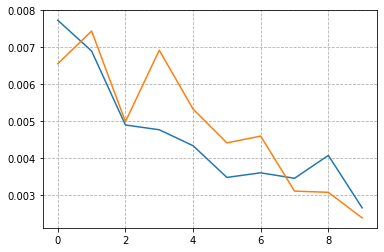

In [ ]:
max_epochs = 10
model.classifier_mode = False
outputs = train(model, mnist_train_dataset, mnist_test_dataset, num_epochs=max_epochs)

아래와 같이 결과를 시각화했을 때, autoencoder만을 사용했을 때만큼의 좋은 결과를 얻었음을 유추할 수 있었다.

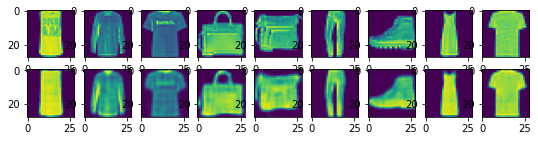

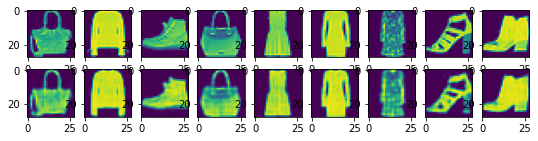

In [ ]:
for k in range(0, max_epochs, 5):
  plt.figure(figsize=(9, 2))
  imgs = outputs[k][1].to('cpu').detach().numpy()
  recon = outputs[k][2].to('cpu').detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9:
      break
    plt.subplot(2, 9, i+1)
    plt.imshow(item[0])
  for i, item in enumerate(recon):
    if i >= 9:
      break
    plt.subplot(2, 9, 9+i+1)
    plt.imshow(item[0])

In [ ]:
torch.save(model, './encoder_model.pth')

# Cluster Test

In [ ]:
df = get_encoder_features(model, mnist_test_dataset)
df.head()

it's on cuda


,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512
0,7,-0.096895,0.573840,-0.456644,-0.413412,-0.005835,0.182960,-0.068035,1.012861,-0.614471,-0.285577,-0.562892,5.238168,-0.017798,0.260092,-0.009912,24.583736,-0.168242,-0.446737,-0.177086,-1.151939,0.265336,0.036931,0.300690,0.593117,-0.484943,-0.279820,-0.363873,-0.455413,0.520669,0.096187,-0.355647,-0.591490,0.198997,0.222395,-1.156908,-0.425168,0.975252,0.415534,-0.697875,...,0.160389,0.167691,1.988074,0.396439,0.409913,-0.226816,-0.598357,0.669935,-0.143876,-0.656930,0.352824,0.678233,-0.464359,-0.081900,0.210473,0.044599,-1.184836,1.008402,0.698683,-0.323500,-0.137219,0.008265,0.485280,0.047661,-0.068938,-0.076876,-0.507317,0.101876,0.619698,-0.670893,-0.544192,-0.376213,-0.404692,-0.268672,1.302946,0.214520,0.706098,0.161161,0.070661,-0.405853
1,0,-0.064636,0.637901,-1.858229,-0.551275,-0.120768,0.601254,-0.444666,-0.618663,0.392253,-0.480783,-0.372730,3.132430,0.147370,0.318328,-0.840236,31.471970,-0.524813,-0.271121,0.462460,-0.305262,-0.974688,0.074420,-0.889471,-0.256430,-0.177242,-0.660596,-0.666539,-0.213986,0.753978,0.568417,-0.104319,-0.029165,0.025899,0.817592,0.283470,-0.710257,0.651327,0.369573,0.666103,...,0.127036,0.073250,2.265777,0.463775,0.072148,1.848385,-0.119873,0.812340,-0.142195,-2.124293,0.324709,-1.107699,0.144157,-0.322271,-1.876494,0.116807,1.475438,-0.335549,-0.082734,-1.317433,-0.435809,0.370358,-0.869163,-1.032072,0.135317,-0.081284,0.638335,0.124984,0.190772,-0.193781,-0.169371,-0.606961,-0.717170,0.057613,1.138826,0.461886,-1.497961,-0.041969,-0.492697,-0.494699
2,4,-0.175003,0.463036,1.077557,-0.340134,-0.061849,0.572724,-0.212676,0.489752,1.291296,0.041390,0.180626,-2.711722,-1.037159,0.316465,2.344384,37.869400,-0.049219,-0.323781,1.823714,0.093940,-2.145794,-0.136706,-0.007470,2.801245,-0.439049,-0.650180,-0.386202,0.216422,2.016394,0.091411,-0.233072,-0.709444,-0.010507,0.504542,0.087277,0.869784,-0.112162,0.208712,-1.962812,...,-0.505477,-0.089060,-0.093118,-0.125233,1.449512,-0.058159,-0.546026,-0.283341,0.293728,1.015559,0.264380,0.235826,0.135328,-0.147419,1.453809,0.091094,-2.532729,0.169752,0.341396,1.590010,1.396555,0.517459,2.057180,0.739207,0.018460,0.081341,-0.539204,0.131120,0.553764,-0.400034,-0.203476,-0.602340,-1.031676,-0.203268,1.964650,0.501684,-0.000578,0.153806,-0.572525,1.145826
3,2,0.089614,1.046514,0.807474,-0.466710,1.167467,0.323354,0.039485,-0.132486,-1.033979,-0.263657,-0.255691,-1.336346,-0.261861,0.518394,0.102380,38.335182,1.165302,-0.140530,0.303741,0.410360,-0.982682,-0.087140,0.673785,1.206902,-0.483847,-0.604445,-0.177742,0.157150,-2.804218,0.703791,-0.677012,-0.400699,0.197951,0.683588,1.811327,-0.261033,-1.174816,0.559706,-1.019221,...,0.036976,-0.261955,0.483006,0.380463,-0.164674,0.003540,0.014233,0.746606,-0.096622,0.309450,0.750482,-0.655384,-0.281776,-0.181412,-0.290268,0.168040,-0.214790,0.265760,1.313920,-1.034925,-0.011968,0.562785,0.154652,-0.564689,0.115203,-0.346760,0.556813,-0.014590,0.171457,0.048264,-0.073257,-0.545124,-0.989336,-0.021244,0.276936,-0.006788,0.372208,0.361392,1.509377,-0.588761
4,1,-0.173494,0.807498,0.356652,0.329292,-1.372389,0.804772,-0.086331,-0.611398,0.677120,0.199336,-0.276401,2.017987,1.077434,0.467619,0.100990,48.551785,-0.188630,-0.024645,-0.296892,-0.601884,-0.636791,0.205171,0.826035,0.001974,-0.219172,-0.516554,0.174650,-0.111337,2.200314,0.389575,-0.439839,-0.749325,0.608598,0.604804,-1.297321,-0.496051,-1.403588,0.479777,-0.808609,...,-0.056699,-0.179138,1.931071,0.391329,0.145912,-0.310627,-0.514830,0.776673,-0.077238,1.059194,0.535497,0.948808,-0.245383,-0.013552,0.448334,0.297347,-1.462159,-0.017457,0.759616,0.741306,0.052776,0.459098,0.875709,-0.456550,-0.054530,0.281940,-0.596615,-0.055145,0.586841,-0.097587,-0.118351,-0.583824,

n_clusters=2 로 설정한 군집화 결과도 이전과 같음을 확인할 수 있었다.

 그리고 역시 2이상의 n_clusters로 군집화 했을 때, 이전 실험과 같이 정확한 군집을 얻을 수 없었다.

In [ ]:
clustering(n_clusters=2, datas=df[range(1,513)], label=df['label'], idx_to_class=idx_to_class)

,std,mean,cluster
label,,,
Ankle boot,0.291975,0.906,0
Bag,0.354283,0.853,0
Coat,0.253581,0.069,1
Dress,0.293362,0.095,1
Pullover,0.350248,0.143,1
Sandal,0.077266,0.994,0
Shirt,0.394070,0.192,1
Sneaker,0.000000,1.000,0
T-shirt/top,0.317970,0.114,1


In [ ]:
clustering(n_clusters=3, datas=df[range(1,513)], label=df['label'], idx_to_class=idx_to_class)

,std,mean,cluster
label,,,
Ankle boot,0.727275,1.660,0
Bag,0.701829,1.673,0
Coat,0.420542,1.111,2
Dress,0.500841,0.653,1
Pullover,0.512810,1.233,2
Sandal,0.735671,0.323,1
Shirt,0.602879,1.130,2
Sneaker,0.740922,0.328,1
T-shirt/top,0.463480,0.799,1


In [ ]:
clustering(n_clusters=7, datas=df[range(1,513)], label=df['label'], idx_to_class=idx_to_class)

,std,mean,cluster
label,,,
Ankle boot,1.171849,2.012,6
Bag,0.977869,2.473,3
Coat,1.421008,0.766,4
Dress,1.797660,1.843,2
Pullover,1.603548,1.198,1
Sandal,0.506762,1.143,1
Shirt,1.654584,1.467,5
Sneaker,0.484877,1.127,1
T-shirt/top,1.589001,1.060,1


10개로 군집화 했을 때도 역시 class대로 군집화가 이루어진 것을 확인할 수 있었다.

In [ ]:
clustering(n_clusters=10, datas=df[range(1,513)], label=df['label'], idx_to_class=idx_to_class)

,std,mean,cluster
label,,,
Ankle boot,1.223435,4.052,2
Bag,1.074914,3.846,6
Coat,1.253933,3.215,8
Dress,1.394724,1.883,3
Pullover,1.272686,3.333,5
Sandal,1.831662,3.037,7
Shirt,1.357569,3.043,9
Sneaker,2.024632,3.158,0
T-shirt/top,1.236246,2.465,4
